In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Define functions

#Generate ellipse profile
def GenEllipse(θ,a,b):
    r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
    return r

#Get ramp vector
def RampVec(θ,ramp_start,ramp_angle,doc):
    ramp_vector = np.zeros(np.size(θ)) #Intialize ramp vector
    ramp_vector[np.logical_and(θ>=ramp_start, θ<=ramp_start+ramp_angle)] = -θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
    return ramp_vector

def EllipseRamp(θ,r,ramp_vector):
    return r-ramp_vector

def GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc):
    doca = (a_initial-a_final)/np.ceil((a_initial-a_final)/doc)
    docb = (b_initial-b_final)/np.ceil((b_initial-b_final)/doc)

    num_revs = int(max(np.ceil((a_initial-a_final)/doc),np.ceil((b_initial-b_final)/doc)))+1
    a_vector = np.linspace(a_initial,a_final,num_revs)
    b_vector = np.linspace(b_initial,b_final,num_revs)

    l_stroke = abs(a_vector-b_vector)

    return doca, a_vector, docb, b_vector, num_revs, l_stroke

def GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc):
    doca, a_vector, docb, b_vector, num_revs, l_stroke = GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc);
    CR_vector = np.zeros([num_revs*len(θ),2])

    for i in range(num_revs):
        a = a_vector[i]
        b = b_vector[i]
#         print(a,b)
        r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
#         print(r)
        CR_vector[i*len(θ):(i+1)*len(θ),0] = i*360+θ
        CR_vector[i*len(θ):(i+1)*len(θ),1] = r
    
    return doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector

def Polar2Cart(θ,r):
    xy = np.zeros([len(θ),2])
    xy[:,0] = r*np.cos(np.deg2rad(θ)) #profile x coordinate
    xy[:,1] = r*np.sin(np.deg2rad(θ)) #profile y coordinate
    return xy

In [3]:
#Define params
θ_step = 0.2
θ = np.arange(0,360,θ_step)

N_work = 50 #[rpm] work-speed
π = np.pi
ω_work = 2*π*N_work/60 #[rad/s] work-speed

a_initial = 48.5
a_final = 48.5

b_initial = 48.5
b_final = 28

doc = 5#0.030; #[mm] depth of cut (max), per revolution
#To see what the code is doing, increase doc to 10 mm.

/Users/brij/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Depth of cut (max): 4100.00 μm/rev
# of work-revs: 6


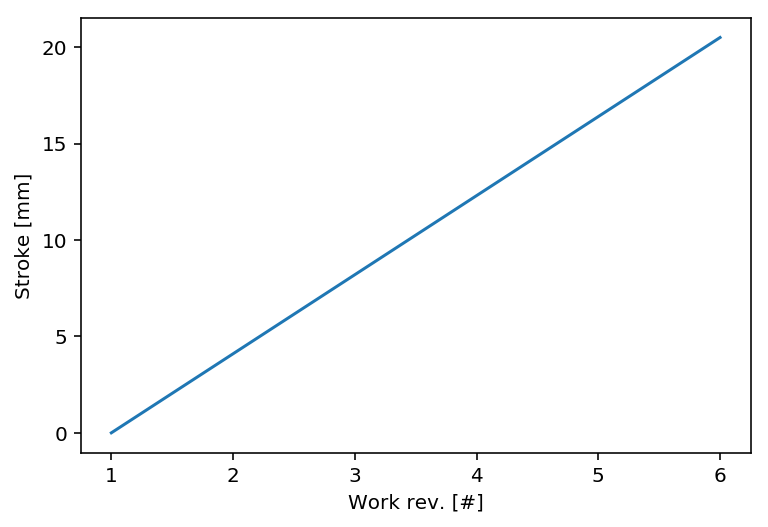

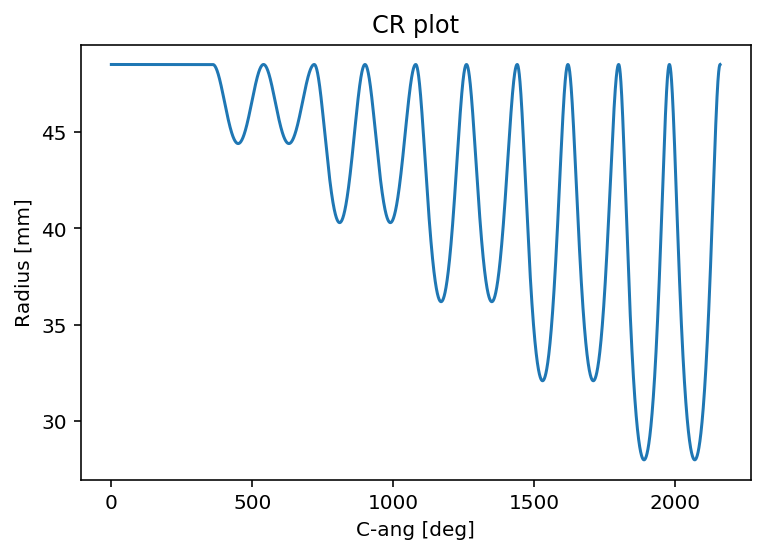

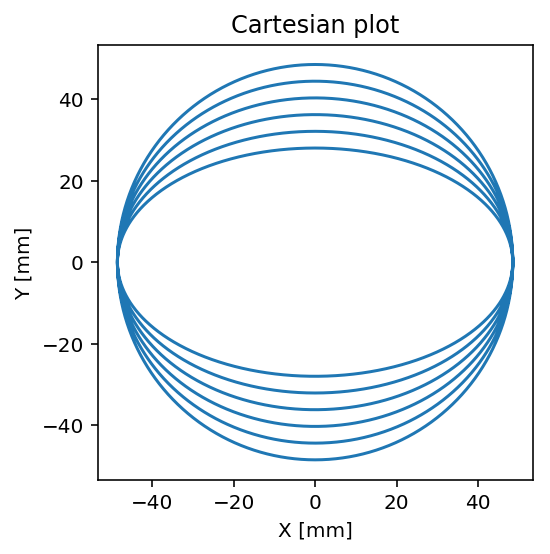

In [4]:
# Generate the CR profile for roughing
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector = GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc)
np.savetxt('CR_5mm_doc.txt',CR_vector, delimiter=',', fmt='%10.6f')   # use exponential notation

print("Depth of cut (max): {:.2f} μm/rev".format(docb*1000))
print("# of work-revs: {:d}".format(num_revs))
plt.plot(range(1,num_revs+1),l_stroke);plt.xlabel('Work rev. [#]');plt.ylabel('Stroke [mm]');
plt.figure();plt.plot(CR_vector[:,0],CR_vector[:,1]);plt.title('CR plot');plt.xlabel('C-ang [deg]');plt.ylabel('Radius [mm]');
XY=Polar2Cart(CR_vector[:,0],CR_vector[:,1])
plt.figure();plt.plot(XY[:,0],XY[:,1]);plt.gca().set_aspect('equal', adjustable='box');plt.title('Cartesian plot');plt.xlabel('X [mm]');plt.ylabel('Y [mm]');

# Characterisitic features of elliptical profile

In [5]:
a = 48.5 #minor radius
b = 28 #major radius

In [6]:
# r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
ṙ = np.gradient(r,θ,edge_order=2) #velcoity
r̈ = np.gradient(ṙ,θ,edge_order=2) #acceleration
r⃛ = np.gradient(r̈,θ,edge_order=1) #jerk

Max interpolation error: 0.147757 μm


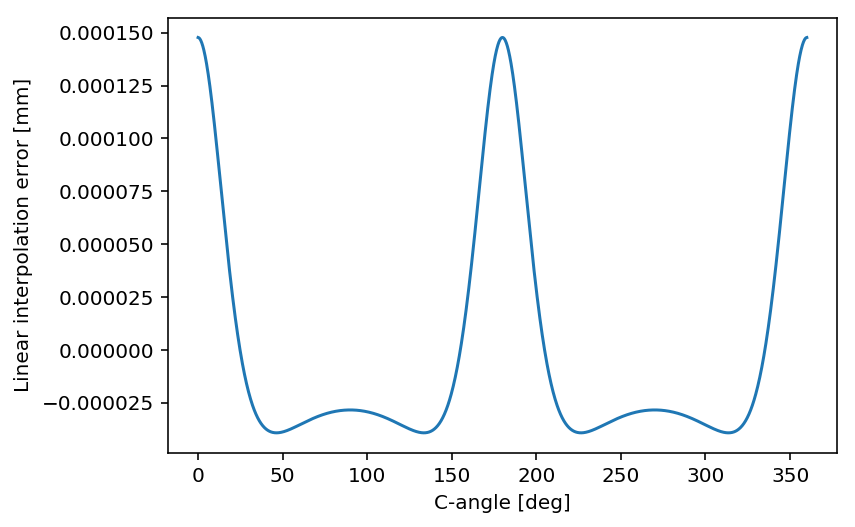

In [7]:
#interpolation error 
#linear as we use G01 command 
#Can be made better if we use G02/G03 command

#Find the mid point acual value between two points and then compare with the avarage radius from the current profile.
θ1 = np.arange(θ_step/2,360,θ_step) #offset and find new theta in between original θ vector
r1 = np.sqrt(1/((np.cos(np.deg2rad(θ1))/a)**2+(np.sin(np.deg2rad(θ1))/b)**2)) #Find the actual value at that location
r_mean_interp = (np.roll(r,-1)+r)/2 #Find average of the radius between two points in the original r-vector
interp_error = r1-r_mean_interp #interpolation error is maximum at the mid-point 

print("Max interpolation error: {:f} μm".format(max(abs(interp_error*1e3))))
plt.plot(θ1,interp_error);plt.xlabel('C-angle [deg]');plt.ylabel('Linear interpolation error [mm]');

In [8]:
x = r*np.cos(np.deg2rad(θ)) #profile x coordinate
y = r*np.sin(np.deg2rad(θ)) #profile y coordinate

Text(0.5, 1.0, 'Ellipse_profile')

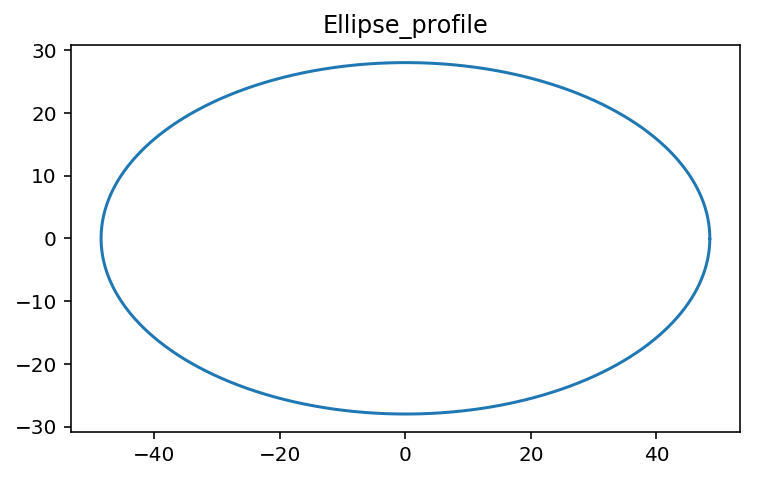

In [9]:
plt.plot(x,y)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Ellipse_profile')

Smooth acceleration, velocity and jerk profiles


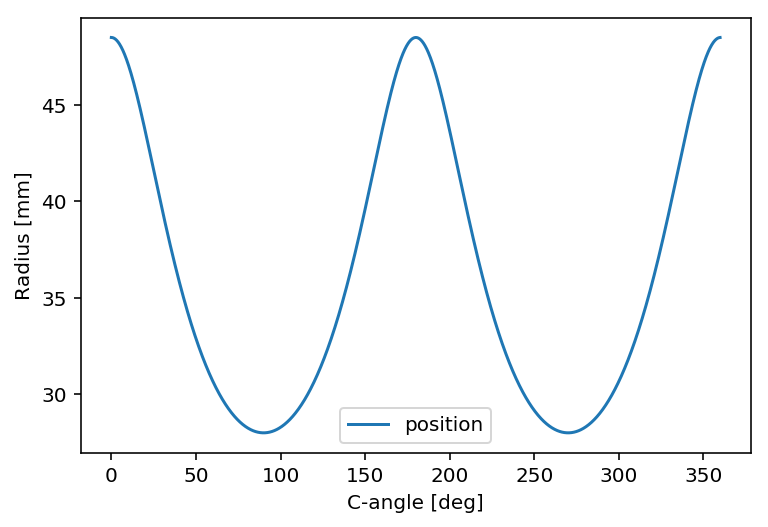

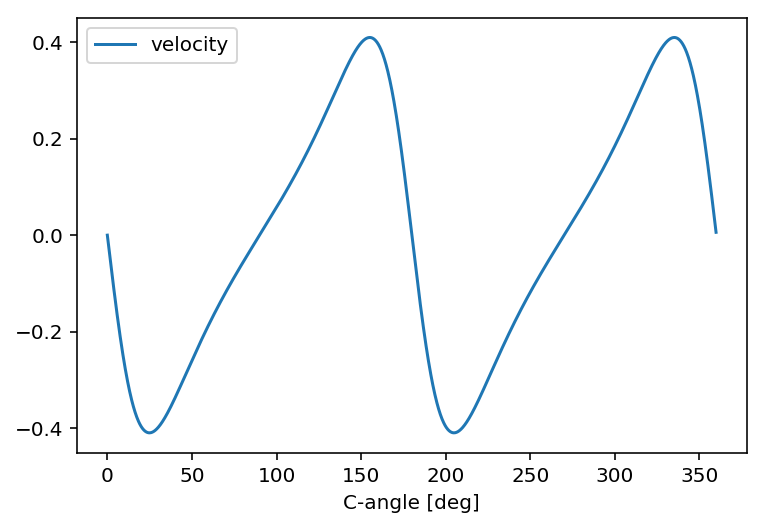

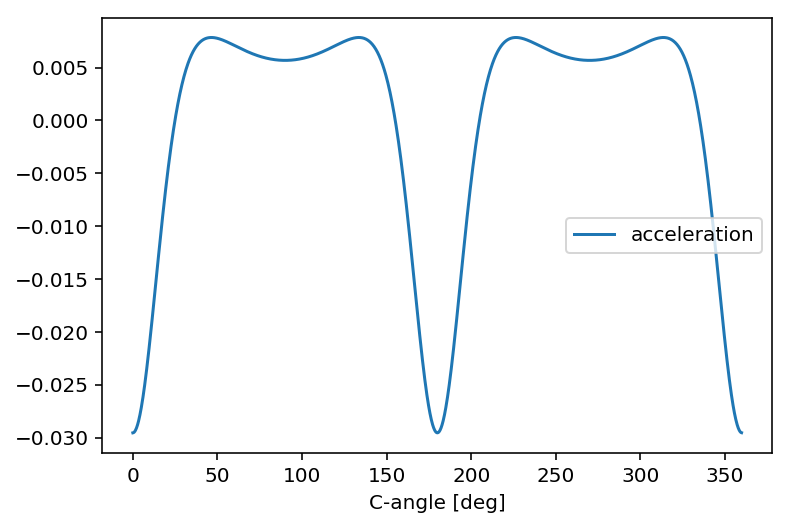

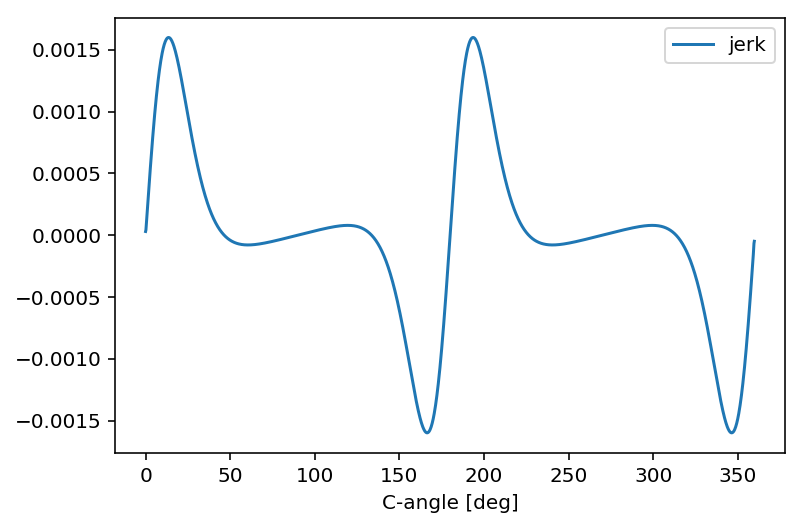

In [10]:
#Plot XVAJ for profile
print("Smooth acceleration, velocity and jerk profiles")
plt.figure()
plt.plot(θ,r,label="position"); plt.legend(); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]')
plt.figure()
plt.plot(θ,ṙ,label="velocity"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r̈,label="acceleration"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r⃛,label="jerk"); plt.legend();plt.xlabel('C-angle [deg]');

In [11]:
#Surface velocity
v_surface = ω_work*r*60/1000 #[m/min]

#depth of cut
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector = GenCutProfile(θ, a, a, b+3*doc, b, doc)
docAng = CR_vector[2*len(θ):(3)*len(θ),1] - CR_vector[3*len(θ):(4)*len(θ),1] #[mm] radial depth of cut 
print(doca,num_revs)

#MRR'
Q_prime = docAng*v_surface #[mm^2/min]

nan 4


/Users/brij/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


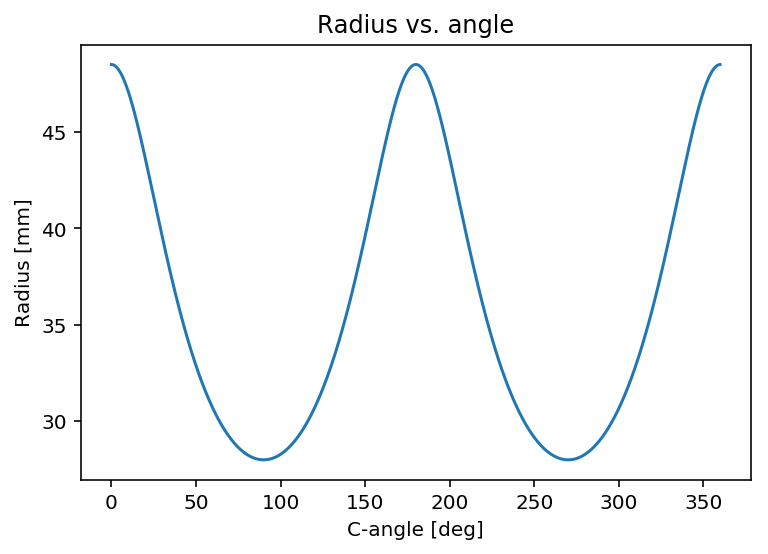

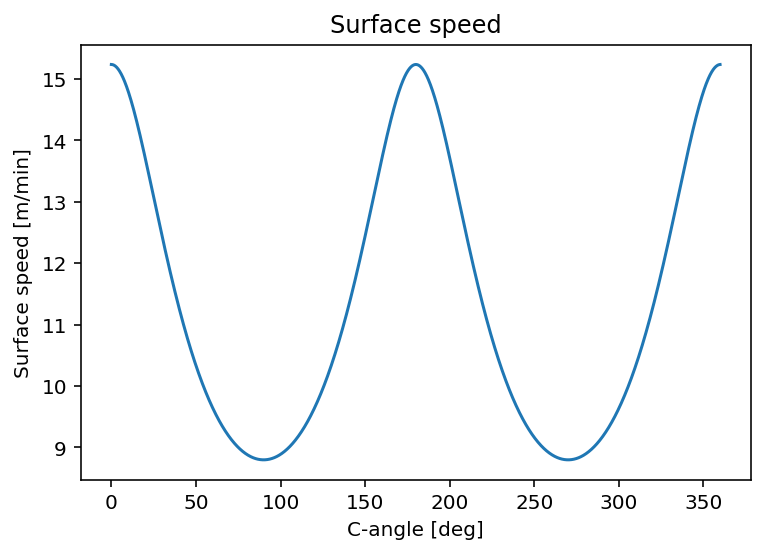

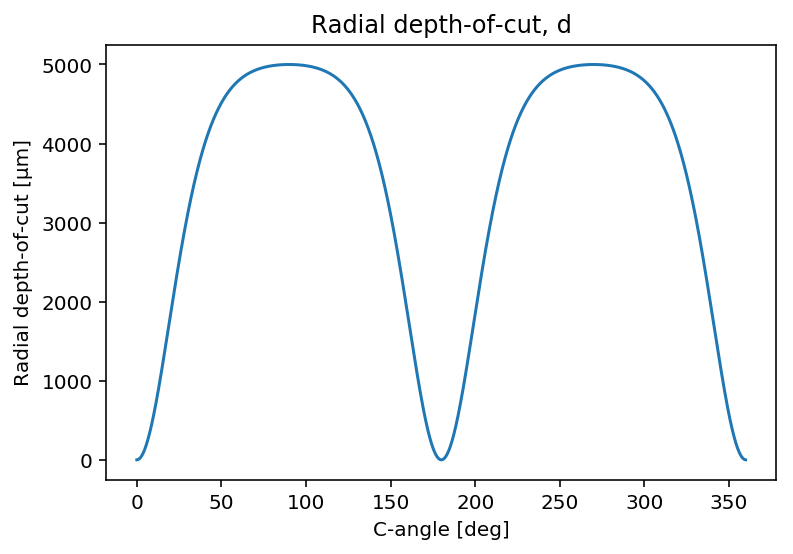

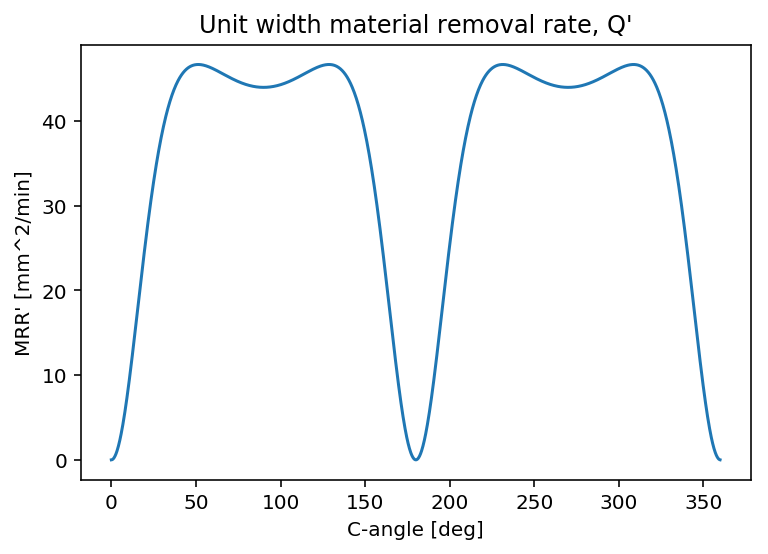

In [12]:
plt.figure()
plt.plot(θ,r); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]');plt.title('Radius vs. angle')
plt.figure()
plt.plot(θ,v_surface);plt.xlabel('C-angle [deg]');plt.ylabel('Surface speed [m/min]'); plt.title('Surface speed');
plt.figure()
plt.plot(θ,docAng*1e3);plt.xlabel('C-angle [deg]');plt.ylabel('Radial depth-of-cut [μm]'); plt.title('Radial depth-of-cut, d');
plt.figure()
plt.plot(θ,Q_prime);plt.xlabel('C-angle [deg]');plt.ylabel('MRR\' [mm^2/min]'); plt.title('Unit width material removal rate, Q\'');

# Sandbox Code, not used

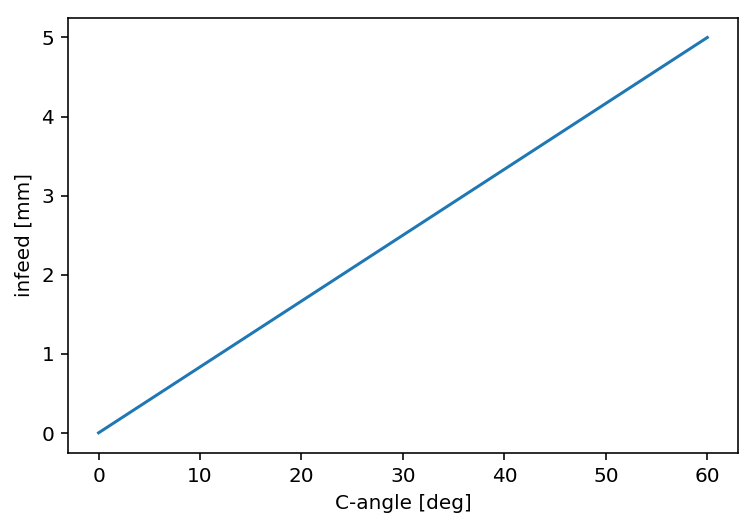

In [13]:
# For ramping the depth of cut
ramp_start = 50 #[deg] Ramp start angle
ramp_angle = 60 #[deg] Ramp angle
ramp_vector = θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
plt.plot(θ[θ<=ramp_angle],ramp_vector); plt.xlabel('C-angle [deg]');plt.ylabel('infeed [mm]');

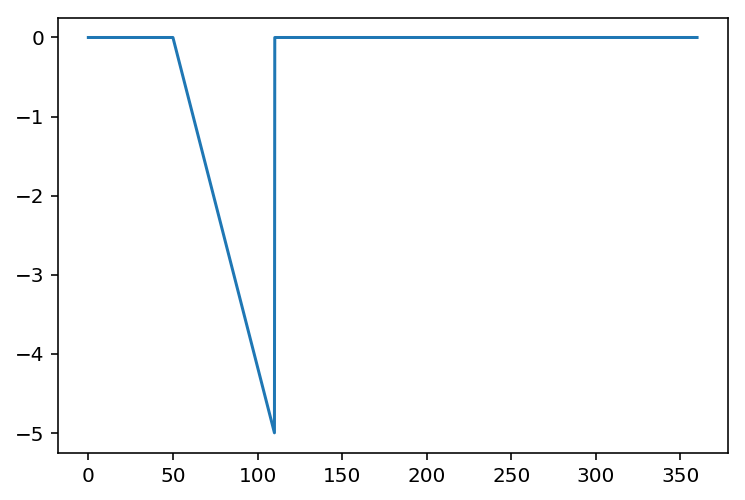

In [14]:
γ = RampVec(θ,ramp_start,ramp_angle,doc)
plt.plot(θ,γ)